<a href="https://colab.research.google.com/github/ImanFakury/imanRepository/blob/master/DeepLearning/CHW3/Q3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DeepLearning Course
## Assignment3-Q3
### Iman Alizadeh Fakouri(401102134)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.datasets import CIFAR10
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision import models
import numpy as np
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device} device")


# Part 1
### Explanation of MobileNetV2 Architecture and Requirements

#### 1. **Network Architecture**:
MobileNetV2 is a lightweight and efficient deep learning model designed for mobile and edge devices. Key features include:
   - **Inverted Residual Blocks**: Instead of traditional residual connections, it uses an "inverted" structure with depthwise separable convolutions.
   - **Depthwise Separable Convolutions**: These reduce computational cost by separating spatial and channel-wise operations.
   - **Linear Bottlenecks**: Preserve low-dimensional embeddings to prevent information loss.

#### 2. **Input Dimensions**:
   - **Expected Size**: The model expects an input size of 3*224*224 (Height: 224 pixels, Width: 224 pixels, and 3 color channels for RGB).
   - **Batch Size**: For inference, inputs must include a batch dimension.

#### 3. **Preprocessing Requirements**:
   - Resize the input image to 224*224 pixels.
   - Convert the image to a tensor.
   - Normalize the image using the following **mean** and **standard deviation** values
   - Add a batch dimension to the tensor before passing it to the model.

#### 4. **Output Dimensions**:
   - The output of MobileNetV2 is a 1D tensor with 1000 values, corresponding to the probabilities of the 1000 ImageNet classes.
   - These values represent logits (unnormalized scores), which can be converted to probabilities using the `softmax` function.

# Part 2

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Class: tabby cat, Probability: 0.6842
Class: tiger cat, Probability: 0.2145
Class: Egyptian Mau, Probability: 0.0835


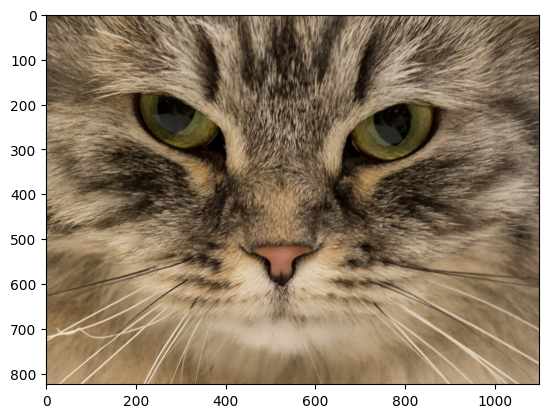

In [7]:
import torch
from torchvision import models, transforms
from PIL import Image
import requests
import json
model = models.mobilenet_v2(pretrained=True)
model.eval()
preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
image_path = "cat.png"
image = Image.open(image_path).convert("RGB")
plt.imshow(image)
input_tensor = preprocess(image).unsqueeze(0)
with torch.no_grad():
    output = model(input_tensor)
imagenet_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
class_labels = requests.get(imagenet_url).json()
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top3_prob, top3_indices = torch.topk(probabilities, 3)
for i in range(3):
    class_name = class_labels[top3_indices[i].item()]
    probability = top3_prob[i].item()
    print(f"Class: {class_name}, Probability: {probability:.4f}")


# Part 3

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_data = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
test_data = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)


train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


In [ ]:
# Check the dataset sizes
print(f"Number of training examples: {len(train_data)}")
print(f"Number of test examples: {len(test_data)}")

Number of training examples: 1020
Number of test examples: 6149


In [ ]:
model = models.mobilenet_v2(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 102)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[1].parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_losses = []
train_accuracies = []
num_epochs=20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    avg_accuracy = 100 * correct_predictions / total_predictions
    train_accuracies.append(avg_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.2f}%')

Epoch [1/20], Loss: 4.4413, Accuracy: 9.71%
Epoch [2/20], Loss: 2.4716, Accuracy: 64.31%
Epoch [3/20], Loss: 1.4052, Accuracy: 89.22%
Epoch [4/20], Loss: 0.8966, Accuracy: 94.22%
Epoch [5/20], Loss: 0.5902, Accuracy: 96.76%
Epoch [6/20], Loss: 0.4306, Accuracy: 98.14%
Epoch [7/20], Loss: 0.3340, Accuracy: 99.22%
Epoch [8/20], Loss: 0.2537, Accuracy: 99.80%
Epoch [9/20], Loss: 0.2033, Accuracy: 99.71%
Epoch [10/20], Loss: 0.1627, Accuracy: 99.90%
Epoch [11/20], Loss: 0.1377, Accuracy: 100.00%
Epoch [12/20], Loss: 0.1197, Accuracy: 100.00%
Epoch [13/20], Loss: 0.1120, Accuracy: 100.00%
Epoch [14/20], Loss: 0.0901, Accuracy: 100.00%
Epoch [15/20], Loss: 0.0791, Accuracy: 100.00%
Epoch [16/20], Loss: 0.0703, Accuracy: 100.00%
Epoch [17/20], Loss: 0.0674, Accuracy: 100.00%
Epoch [18/20], Loss: 0.0604, Accuracy: 100.00%
Epoch [19/20], Loss: 0.0525, Accuracy: 100.00%
Epoch [20/20], Loss: 0.0503, Accuracy: 100.00%


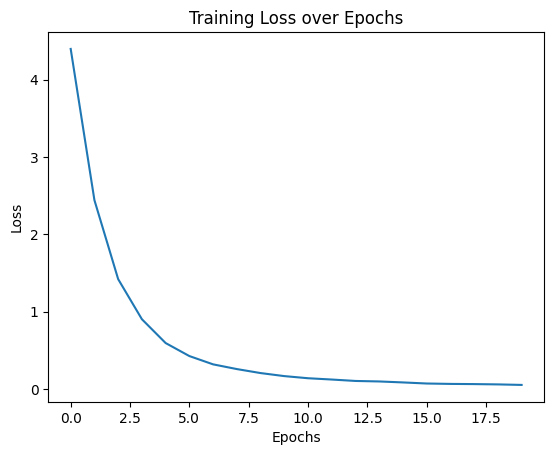

In [ ]:
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

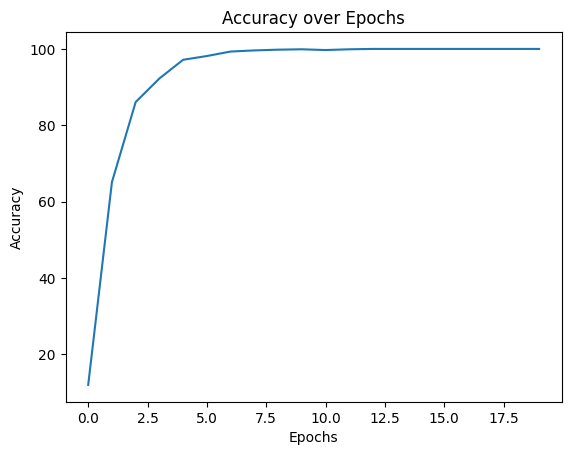

In [ ]:
plt.plot(train_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.show()

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Train Accuracy: {100 * correct / total:.2f}%')

Train Accuracy: 85.20%


# Part 4
## VGG16

In [ ]:
model =models.vgg16(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 102)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)

In [ ]:
train_losses = []
train_accuracies = []
num_epochs=20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    avg_accuracy = 100 * correct_predictions / total_predictions
    train_accuracies.append(avg_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.2f}%')


Epoch [1/20], Loss: 0.8111, Accuracy: 86.08%
Epoch [2/20], Loss: 0.5637, Accuracy: 90.39%
Epoch [3/20], Loss: 0.4381, Accuracy: 93.63%
Epoch [4/20], Loss: 0.3431, Accuracy: 95.10%
Epoch [5/20], Loss: 0.2732, Accuracy: 97.25%
Epoch [6/20], Loss: 0.2330, Accuracy: 97.16%
Epoch [7/20], Loss: 0.1987, Accuracy: 98.14%
Epoch [8/20], Loss: 0.1689, Accuracy: 98.73%
Epoch [9/20], Loss: 0.1555, Accuracy: 98.63%
Epoch [10/20], Loss: 0.1419, Accuracy: 97.84%
Epoch [11/20], Loss: 0.1091, Accuracy: 99.41%
Epoch [12/20], Loss: 0.1013, Accuracy: 99.31%
Epoch [13/20], Loss: 0.0871, Accuracy: 99.80%
Epoch [14/20], Loss: 0.0815, Accuracy: 99.51%
Epoch [15/20], Loss: 0.0868, Accuracy: 99.51%
Epoch [16/20], Loss: 0.0771, Accuracy: 99.51%
Epoch [17/20], Loss: 0.0692, Accuracy: 99.51%
Epoch [18/20], Loss: 0.0557, Accuracy: 99.90%
Epoch [19/20], Loss: 0.0614, Accuracy: 99.80%
Epoch [20/20], Loss: 0.0590, Accuracy: 99.51%


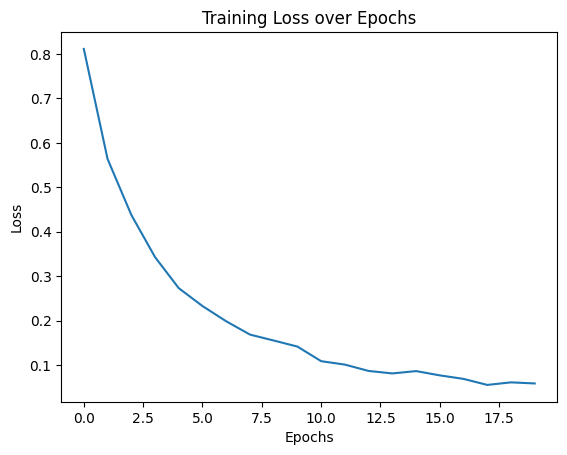

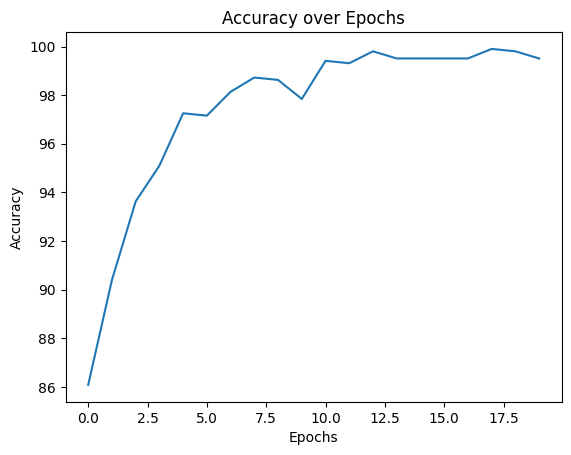

In [ ]:
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

plt.plot(train_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.show()

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Train Accuracy: {100 * correct / total:.2f}%')

Train Accuracy: 72.63%


# Part 4
## ResNet50

In [ ]:
model =models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 102)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
train_losses = []
train_accuracies = []
num_epochs=20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    avg_accuracy = 100 * correct_predictions / total_predictions
    train_accuracies.append(avg_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.2f}%')


Epoch [1/20], Loss: 4.6279, Accuracy: 8.53%
Epoch [2/20], Loss: 2.6411, Accuracy: 57.94%
Epoch [3/20], Loss: 1.5338, Accuracy: 85.20%
Epoch [4/20], Loss: 0.9411, Accuracy: 92.65%
Epoch [5/20], Loss: 0.6801, Accuracy: 94.80%
Epoch [6/20], Loss: 0.4771, Accuracy: 97.16%
Epoch [7/20], Loss: 0.3307, Accuracy: 99.22%
Epoch [8/20], Loss: 0.2742, Accuracy: 99.22%
Epoch [9/20], Loss: 0.2071, Accuracy: 99.80%
Epoch [10/20], Loss: 0.1716, Accuracy: 99.90%
Epoch [11/20], Loss: 0.1433, Accuracy: 100.00%
Epoch [12/20], Loss: 0.1225, Accuracy: 100.00%
Epoch [13/20], Loss: 0.1076, Accuracy: 99.90%
Epoch [14/20], Loss: 0.0963, Accuracy: 100.00%
Epoch [15/20], Loss: 0.0772, Accuracy: 100.00%
Epoch [16/20], Loss: 0.0710, Accuracy: 100.00%
Epoch [17/20], Loss: 0.0668, Accuracy: 100.00%
Epoch [18/20], Loss: 0.0627, Accuracy: 100.00%
Epoch [19/20], Loss: 0.0537, Accuracy: 100.00%
Epoch [20/20], Loss: 0.0487, Accuracy: 100.00%


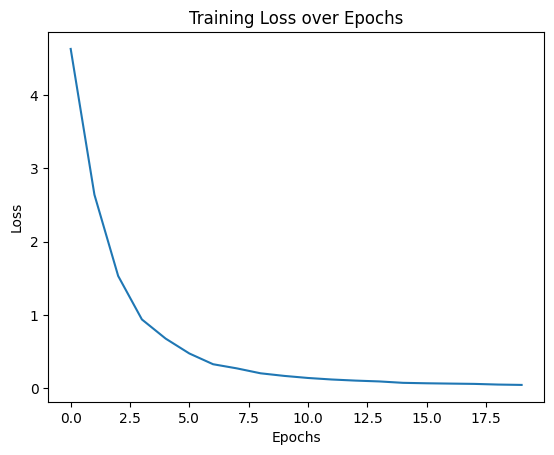

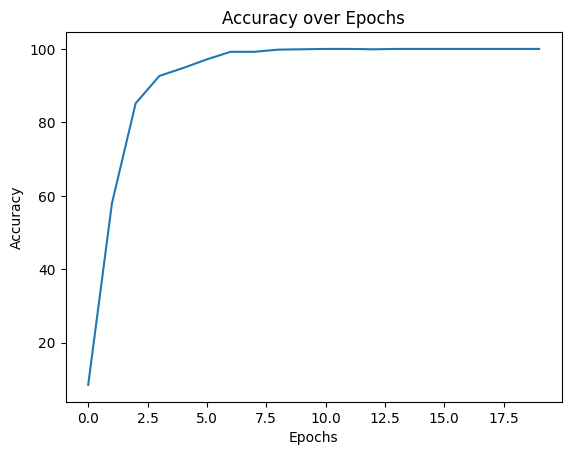

In [ ]:
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

plt.plot(train_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.show()

In [ ]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Train Accuracy: {100 * correct / total:.2f}%')

Train Accuracy: 83.90%


# Comparison

In [11]:
import torch
from torchvision import models

def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    learnable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, learnable_params

def freeze_except_classifier(model, classifier_name):
    for name, param in model.named_parameters():
        if not name.startswith(classifier_name):
            param.requires_grad = False
mobilenet_v2 = models.mobilenet_v2(pretrained=True)
resnet50 = models.resnet50(pretrained=True)
vgg16 = models.vgg16(pretrained=True)

freeze_except_classifier(mobilenet_v2, "classifier")
freeze_except_classifier(resnet50, "fc")
freeze_except_classifier(vgg16, "classifier")

models_to_compare = {
    "MobileNetV2": mobilenet_v2,
    "ResNet50": resnet50,
    "VGG16": vgg16
}

print(f"{'Model':<15} {'Total Params':<15} {'Learnable Params':<15}")
for model_name, model in models_to_compare.items():
    total, learnable = count_parameters(model)
    print(f"{model_name:<15} {total:<15,} {learnable:<15,}")


Model           Total Params    Learnable Params
MobileNetV2     3,504,872       1,281,000      
ResNet50        25,557,032      2,049,000      
VGG16           138,357,544     123,642,856    


Here is the table summarizing the **model parameters** and **accuracies**:

| **Model**       | **Total Params**   | **Learnable Params** | **Accuracy (%)** |
|------------------|--------------------|-----------------------|------------------|
| **MobileNetV2**  | 3,504,872         | 1,281,000             | 85.20           |
| **ResNet50**     | 25,557,032        | 2,049,000             | 83.90           |
| **VGG16**        | 138,357,544       | 123,642,856           | 72.63           |

---

### Explanation of Accuracies:
#### 1. **MobileNetV2 (Accuracy: 85.20%)**
   - **Architecture**: MobileNetV2 is designed for efficiency and achieves high accuracy with significantly fewer parameters. The use of **depthwise separable convolutions** reduces the number of computations while retaining feature extraction quality.
   - **Learnable Parameters**: With a smaller classifier, the network can generalize well on tasks, especially when trained with a frozen backbone.
   - **Performance**: Its lightweight nature helps maintain strong accuracy even with fewer learnable parameters.

#### 2. **ResNet50 (Accuracy: 83.90%)**
   - **Architecture**: ResNet50's **residual connections** help mitigate vanishing gradient issues, allowing deeper networks to converge effectively. Its architecture is balanced, making it suitable for diverse tasks.
   - **Learnable Parameters**: While the number of learnable parameters is slightly higher than MobileNetV2, ResNet50 doesn't heavily overfit due to its architectural efficiency.
   - **Performance**: Strong accuracy is achieved due to its ability to learn complex patterns, though it's slightly behind MobileNetV2 because of possible overfitting or computational inefficiency compared to MobileNetV2.

#### 3. **VGG16 (Accuracy: 72.63%)**
   - **Architecture**: VGG16 uses a simple stack of convolutional layers, resulting in an extremely large parameter count. However, it lacks the advanced features of modern architectures like residual connections or depthwise convolutions.
   - **Learnable Parameters**: VGG16's classifier accounts for the majority of learnable parameters, leading to a high risk of overfitting, especially when the dataset size is limited.
   - **Performance**: The large number of parameters and outdated architecture contribute to relatively lower accuracy, as the model may struggle to generalize effectively.

---

### Why the Results Differ:
1. **Parameter Efficiency**:  
   - MobileNetV2 achieves higher accuracy with far fewer parameters due to its efficient design.
   - VGG16, despite having more parameters, performs worse because it is less efficient at learning patterns.
   
2. **Overfitting**:  
   - VGG16's massive parameter count leads to overfitting on smaller datasets.
   - MobileNetV2 and ResNet50, with smaller or well-distributed parameters, are less prone to overfitting.

3. **Modern Architectural Innovations**:  
   - MobileNetV2 and ResNet50 use modern techniques (e.g., residual connections, depthwise separable convolutions) that enhance learning and generalization.
   - VGG16 lacks these advancements, making it less effective on modern datasets.


# Part 5

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
test_data = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)


model = models.mobilenet_v2(pretrained=False)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_ftrs, 102)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


train_losses = []
train_accuracies = []
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == targets).sum().item()
        total_predictions += targets.size(0)

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)
    avg_accuracy = 100 * correct_predictions / total_predictions
    train_accuracies.append(avg_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {avg_accuracy:.2f}%')


Epoch [1/20], Loss: 4.8511, Accuracy: 1.08%
Epoch [2/20], Loss: 4.2417, Accuracy: 4.12%
Epoch [3/20], Loss: 3.8457, Accuracy: 6.47%
Epoch [4/20], Loss: 3.5928, Accuracy: 10.00%
Epoch [5/20], Loss: 3.3784, Accuracy: 13.14%
Epoch [6/20], Loss: 3.1356, Accuracy: 15.98%
Epoch [7/20], Loss: 3.0218, Accuracy: 17.55%
Epoch [8/20], Loss: 2.8935, Accuracy: 21.08%
Epoch [9/20], Loss: 2.8255, Accuracy: 22.94%
Epoch [10/20], Loss: 2.5715, Accuracy: 26.37%
Epoch [11/20], Loss: 2.4533, Accuracy: 28.53%
Epoch [12/20], Loss: 2.3988, Accuracy: 31.76%
Epoch [13/20], Loss: 2.2379, Accuracy: 35.39%
Epoch [14/20], Loss: 1.9763, Accuracy: 42.84%
Epoch [15/20], Loss: 1.7493, Accuracy: 47.75%
Epoch [16/20], Loss: 1.6960, Accuracy: 49.31%
Epoch [17/20], Loss: 1.5787, Accuracy: 53.24%
Epoch [18/20], Loss: 1.4261, Accuracy: 55.69%
Epoch [19/20], Loss: 1.3307, Accuracy: 60.49%
Epoch [20/20], Loss: 1.1288, Accuracy: 65.88%


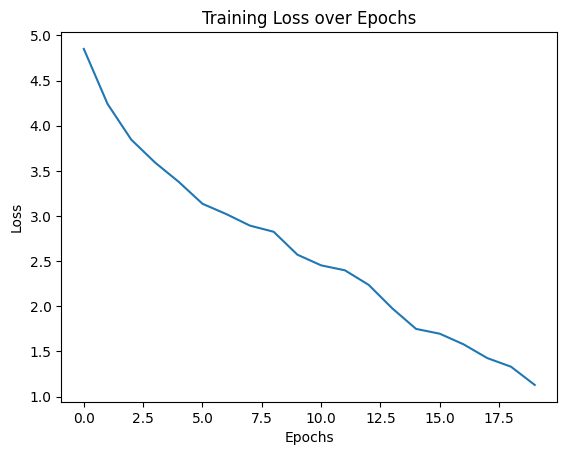

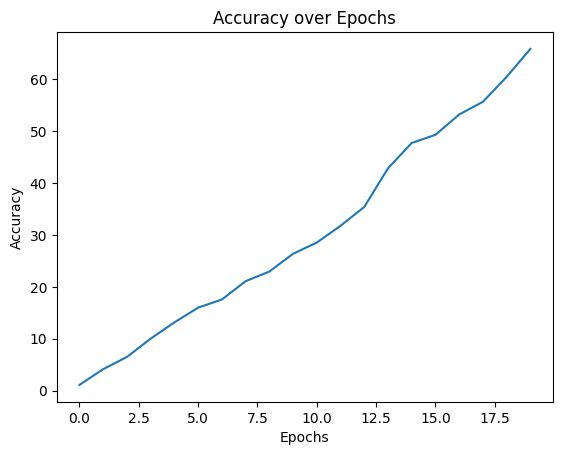

In [14]:
plt.plot(train_losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

plt.plot(train_accuracies)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.show()

In [15]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

print(f'Train Accuracy: {100 * correct / total:.2f}%')

Train Accuracy: 14.93%


The reason why the accuracy is lower in the method where the model is trained from scratch (without transfer learning) compared to the transfer learning approach is due to several key factors related to how deep learning models learn and generalize:
   - **Transfer learning** uses a model that has already been pre-trained on a large and diverse dataset (like ImageNet), which means it has already learned useful low-level features (such as edges, textures, and shapes) and high-level representations (such as object parts or patterns).
   - When you fine-tune the model on your specific task (e.g., Flowers102), it doesn't start from random weights. Instead, the model starts with a good understanding of general features that are likely to be useful for many types of images, so it can quickly adapt to your specific problem.
   - **Result**: With transfer learning, the model benefits from these learned features, which accelerates learning and improves performance, especially when the new dataset is relatively small or similar to the original dataset.
